# Data loader

2023/04/02
Cell Ranger v7.0.0 chemistry: SC 3P v3, force_cells: N/A, include_introns: true, no_bam: true, no_secondary_analysis: true GRCh38-2020-A 2020-A Single Cell 3’ Gene Expression

Control: 14, 409, 4092(409 #2), 1516, 15162(1516 #2), 729, 1432, 1532, T136, T1952, T551, T99

SCA1: 11, 12, 122 (12 #2), 13, 132(13 #2), CB, CT, RT, CNGA-0047, CNGA-0061, CNGA-0064, UMB1354


In [1]:
# Import packages
import os, sys, glob, re, math, pickle
import phate, scprep, magic, meld
import graphtools as gt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time,random,datetime
import networkx as nx
import scvelo as scv
from sklearn import metrics
from sklearn import model_selection
from scipy import sparse
from scipy.stats import mannwhitneyu, tiecorrect, rankdata
from statsmodels.stats.multitest import multipletests
import scanpy as sc
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import SpectralClustering, OPTICS, cluster_optics_dbscan, AgglomerativeClustering
from bbknn import bbknn
%matplotlib inline
%load_ext memory_profiler
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=True
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=9)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1

# reproducibility
rs = np.random.seed(42)

In [2]:
# fps
dfp = '/home/cl2292/project/SCA1_snRNAseq/Human/data/'
pfp = '/home/cl2292/project/SCA1_snRNAseq/Human/results_20230402/'
pdfp = '/home/cl2292/project/SCA1_snRNAseq/Human/data/processed/'
sc.settings.figdir = pfp

In [3]:
# loader
#                 - Ctrl = 14, 409, 4092, 1516, 15162, 729, 1432, 1532, T136, T1952, T551, T99
#                 - SCA1 = 11, 12, 13, 122, 132, CB, CT, RT, CNGA-0047, CNGA-0061, CNGA-0064, UMB1354
data_folders = ['/home/cl2292/project/SCA1_snRNAseq/Human/data/Ctrl_14',
                '/home/cl2292/project/SCA1_snRNAseq/Human/data/Ctrl_409',
                '/home/cl2292/project/SCA1_snRNAseq/Human/data/Ctrl_4092',
                '/home/cl2292/project/SCA1_snRNAseq/Human/data/Ctrl_1516',
                '/home/cl2292/project/SCA1_snRNAseq/Human/data/Ctrl_15162',
                '/home/cl2292/project/SCA1_snRNAseq/Human/data/Ctrl_729',
                '/home/cl2292/project/SCA1_snRNAseq/Human/data/Ctrl_1432',
                '/home/cl2292/project/SCA1_snRNAseq/Human/data/Ctrl_1532',
                '/home/cl2292/project/SCA1_snRNAseq/Human/data/Ctrl_T136',
                '/home/cl2292/project/SCA1_snRNAseq/Human/data/Ctrl_T1952',
                '/home/cl2292/project/SCA1_snRNAseq/Human/data/Ctrl_T551',
                '/home/cl2292/project/SCA1_snRNAseq/Human/data/Ctrl_T99',
                '/home/cl2292/project/SCA1_snRNAseq/Human/data/SCA1_11',
                '/home/cl2292/project/SCA1_snRNAseq/Human/data/SCA1_12',
                '/home/cl2292/project/SCA1_snRNAseq/Human/data/SCA1_122',
                '/home/cl2292/project/SCA1_snRNAseq/Human/data/SCA1_13',
                '/home/cl2292/project/SCA1_snRNAseq/Human/data/SCA1_132',
                '/home/cl2292/project/SCA1_snRNAseq/Human/data/SCA1_CB',
                '/home/cl2292/project/SCA1_snRNAseq/Human/data/SCA1_CT',
                '/home/cl2292/project/SCA1_snRNAseq/Human/data/SCA1_RT',
                '/home/cl2292/project/SCA1_snRNAseq/Human/data/SCA1_CNGA-0047',
                '/home/cl2292/project/SCA1_snRNAseq/Human/data/SCA1_CNGA-0061',
                '/home/cl2292/project/SCA1_snRNAseq/Human/data/SCA1_CNGA-0064',
                '/home/cl2292/project/SCA1_snRNAseq/Human/data/SCA1_UMB1354',
               ]

files_not_found = []
for i in data_folders :
    if not os.path.exists(i) :
        files_not_found.append(i)
    if not files_not_found == [] :
        print('Folders not found...')
        for j in files_not_found :
            print(j)
        raise IOError('Change path to data')

total = time.time()


In [4]:
# first loader

running_cellcount=0
start = time.time()
adatas = {}
for i,folder in enumerate(data_folders) :
    sample_id = os.path.split(folder)[1][5:]
    print(sample_id)
    print('... storing %s into dict (%d/%d)' % (sample_id,i+1,len(data_folders)))
    adatas[sample_id] = sc.read_10x_mtx(folder)
    running_cellcount+=adatas[sample_id].shape[0]
    print('...     read {} cells; total: {} in {:.2f}-s'.format(adatas[sample_id].shape[0],running_cellcount,time.time()-start))
batch_names = list(adatas.keys())


14
... storing 14 into dict (1/24)
...     read 5218 cells; total: 5218 in 8.88-s
409
... storing 409 into dict (2/24)
...     read 2672 cells; total: 7890 in 21.32-s
4092
... storing 4092 into dict (3/24)
...     read 6794 cells; total: 14684 in 68.30-s
1516
... storing 1516 into dict (4/24)
...     read 9994 cells; total: 24678 in 120.41-s
15162
... storing 15162 into dict (5/24)
...     read 19435 cells; total: 44113 in 210.71-s
729
... storing 729 into dict (6/24)
...     read 16029 cells; total: 60142 in 293.31-s
1432
... storing 1432 into dict (7/24)
...     read 5578 cells; total: 65720 in 332.44-s
1532
... storing 1532 into dict (8/24)
...     read 5658 cells; total: 71378 in 364.06-s
T136
... storing T136 into dict (9/24)
...     read 21674 cells; total: 93052 in 496.06-s
T1952
... storing T1952 into dict (10/24)
...     read 14898 cells; total: 107950 in 586.82-s
T551
... storing T551 into dict (11/24)
...     read 20766 cells; total: 128716 in 706.73-s
T99
... storing T99 in

In [5]:
## Scrublet

for i in batch_names:
    sc.external.pp.scrublet(adatas[i])
    adatas[i].var_names_make_unique()
    adatas[i].obs_names_make_unique()

Running Scrublet
filtered out 13963 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.54
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 3.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.5%
    Scrublet finished (0:00:04)
Running Scrublet
filtered out 13108 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.43
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 18.4%

filtered out 8156 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.67
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 6.1%
    Scrublet finished (0:00:17)
Running Scrublet
filtered out 8064 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.39
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 11.6%
Overall doublet ra

In [6]:
## Merge
print('\n... concatenating of {}-samples'.format(len(data_folders)))
adata = adatas[batch_names[0]].concatenate(adatas[batch_names[1]],adatas[batch_names[2]],
                                               adatas[batch_names[3]],adatas[batch_names[4]],
                                               adatas[batch_names[5]],adatas[batch_names[6]],
                                               adatas[batch_names[7]],adatas[batch_names[8]],
                                               adatas[batch_names[9]],adatas[batch_names[10]],
                                               adatas[batch_names[11]],adatas[batch_names[12]],
                                               adatas[batch_names[13]],adatas[batch_names[14]],
                                               adatas[batch_names[15]],adatas[batch_names[16]],
                                               adatas[batch_names[17]],adatas[batch_names[18]],
                                               adatas[batch_names[19]],adatas[batch_names[20]],
                                               adatas[batch_names[21]],adatas[batch_names[22]],
                                               adatas[batch_names[23]],
                                               batch_categories = batch_names)
print('Raw load in {:.2f}-min'.format((time.time() - start)/60))

print('Ncells=%d are doublets' % np.sum(adata.obs.predicted_doublet != False))
#adata = adata[adata.obs.predicted_doublet == False, :]
adata


... concatenating of 24-samples
Raw load in 29.58-min
Ncells=675 are doublets


AnnData object with n_obs × n_vars = 245397 × 36601
    obs: 'doublet_score', 'predicted_doublet', 'batch'
    var: 'gene_ids', 'feature_types'

In [7]:
# annotate metadata
Ctrl = ['14', '409', '4092', '1516', '15162', '729', '1432', '1532', 'T136', 'T1952', 'T551', 'T99']
SCA1 = ['11', '12', '13', '122', '132', 'CB', 'CT', 'RT', 'CNGA-0047', 'CNGA-0061', 'CNGA-0064', 'UMB1354']

genotype = []
for i in adata.obs['batch'] : # verbose loop for quality-assurance
    if i in Ctrl :
        genotype.append('Ctrl')
    elif i in SCA1 :
        genotype.append('SCA1')  
    else :
        raise ValueError('Encountered unclassifiable genotype for sample {}'.format(i))
adata.obs['genotype']=genotype


print(adata)

AnnData object with n_obs × n_vars = 245397 × 36601
    obs: 'doublet_score', 'predicted_doublet', 'batch', 'genotype'
    var: 'gene_ids', 'feature_types'


In [8]:
print(adata.obs['batch'].value_counts())
print("")
print(adata.obs['genotype'].value_counts())

T136         21674
T551         20766
15162        19435
729          16029
T1952        14898
13           14340
CNGA-0064    14229
T99          14222
CNGA-0047    10363
1516          9994
UMB1354       9905
CB            9778
CNGA-0061     9592
11            8624
RT            8494
132           8026
4092          6794
122           5821
1532          5658
1432          5578
14            5218
409           2672
12            1976
CT            1311
Name: batch, dtype: int64

Ctrl    142938
SCA1    102459
Name: genotype, dtype: int64


In [9]:
# filter cells/genes, transform
adata.var['MT'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['MT'], inplace=True)
print('Ncells=%d have >10 percent mt expression' % np.sum(adata.obs['pct_counts_mt']>20))

adata.obs['pmito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
print('Ncells=%d have >10 percent mt expression' % np.sum(adata.obs['pmito']>0.1))
print('Ncells=%d have <200 genes expressed' % np.sum(adata.obs['n_genes_by_counts']<200))
print('Ncells=%d have <500 counts' % np.sum(adata.obs['total_counts']<500))
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_cells(adata, min_counts = 500)
sc.pp.filter_genes(adata, min_cells=3) # filtering cells gets rid of some genes of interest; redundant with Scrublet?
adata = adata[adata.obs.pmito <= 0.1, :]
adata.raw = adata
sc.pp.normalize_total(adata)
sc.pp.sqrt(adata)

Ncells=7246 have >10percent mt expression
Ncells=279 have <200 genes expressed
Ncells=0 have <500 counts
filtered out 279 cells that have less than 200 genes expressed
filtered out 2171 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:04)


In [10]:
print(adata)

AnnData object with n_obs × n_vars = 238149 × 34430
    obs: 'doublet_score', 'predicted_doublet', 'batch', 'genotype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pmito', 'n_genes', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'


In [11]:
print(adata.obs['batch'].value_counts())
print("")
print(adata.obs['genotype'].value_counts())

T136         21449
T551         20665
15162        19401
729          15565
T1952        14681
13           14108
CNGA-0064    13974
T99          13771
CNGA-0047    10142
1516          9960
UMB1354       9791
CB            9612
CNGA-0061     9551
11            8482
RT            8015
132           7815
4092          6098
1432          5420
14            5194
1532          5160
122           4322
409           2554
12            1735
CT             684
Name: batch, dtype: int64

Ctrl    139918
SCA1     98231
Name: genotype, dtype: int64


In [12]:
# save data objects
adata.write(os.path.join(pdfp,'230419_human_SCA1_noscrublet.h5ad'))
print('saved @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))

... storing 'genotype' as categorical
... storing 'feature_types' as categorical
... storing 'feature_types' as categorical


saved @230419.10:53:47


In [14]:
# calc embeddings for batch corrected BBKNN
start = time.time()
print('starting embeddings...')
sc.tl.pca(adata,n_comps=100)
sc.external.pp.bbknn(adata,batch_key='batch')
sc.tl.louvain(adata,resolution=5)

starting embeddings...
computing PCA
    with n_comps=100
    finished (0:12:22)
computing batch balanced neighbors
	finished (0:02:47)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:04:42)


computing UMAP
    finished (0:08:30)


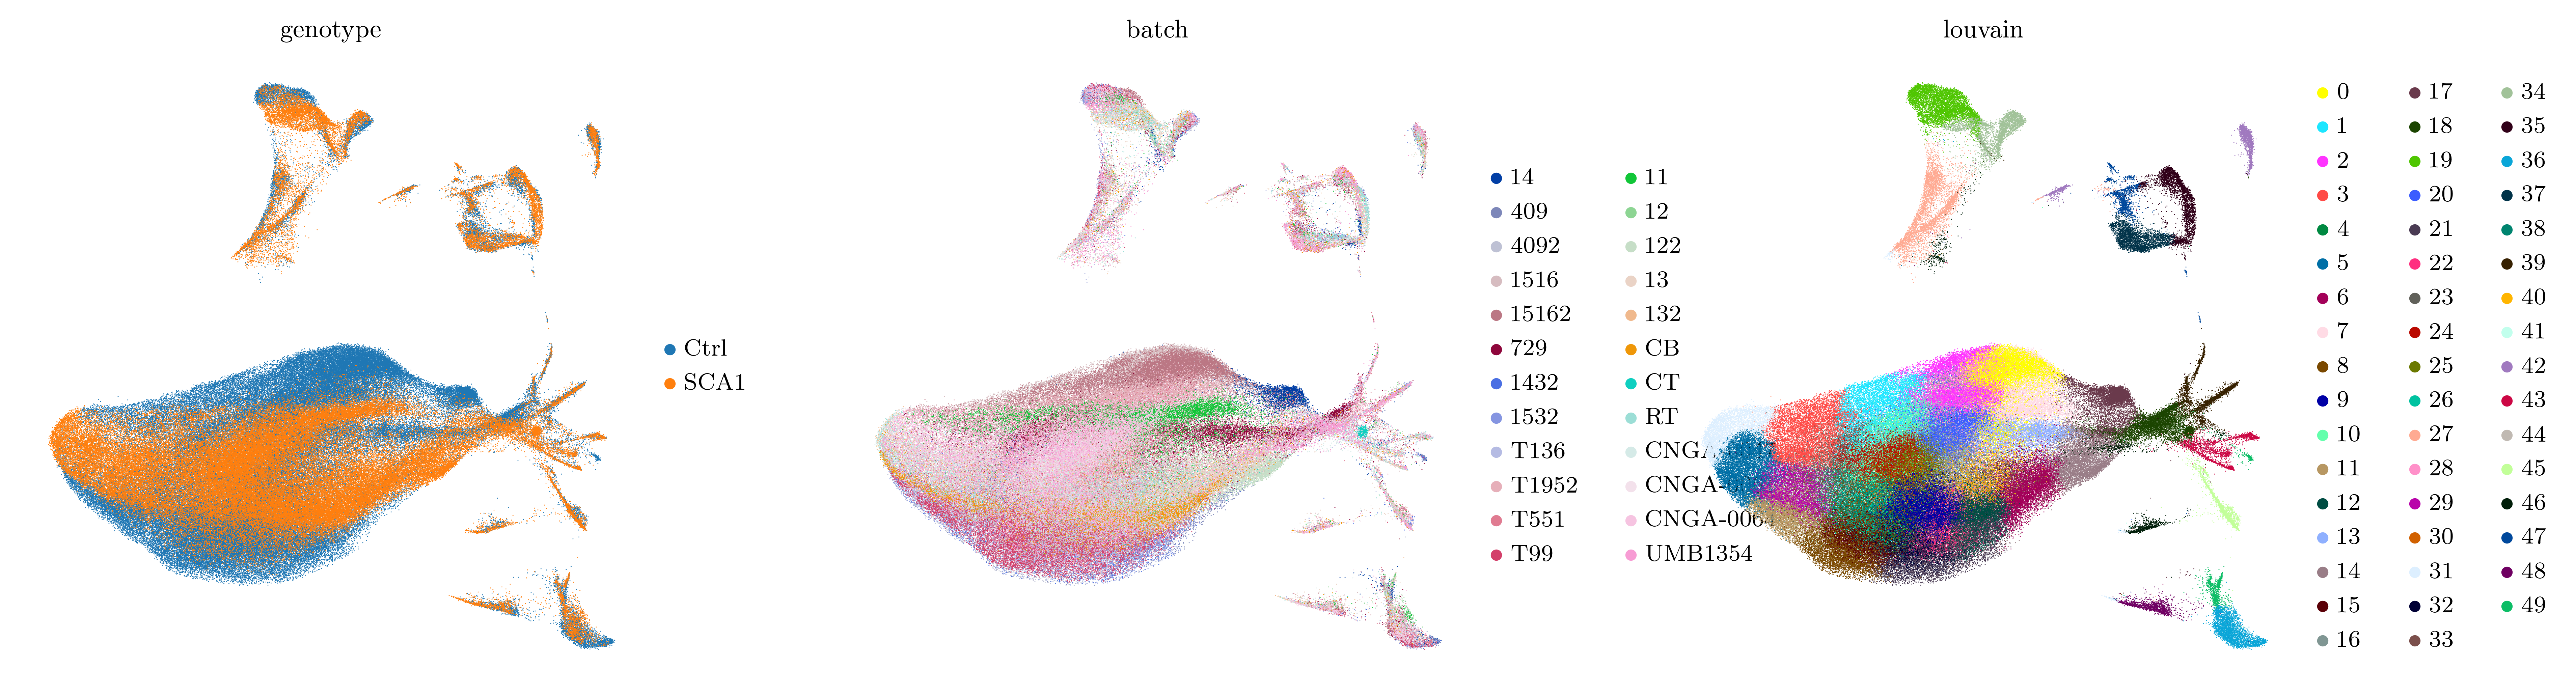

In [15]:
sc.tl.umap(adata, min_dist = 0.4, spread = 1.5)
sc.pl.umap(adata, color=['genotype', 'batch','louvain'], save = '230419_d04_sp15_noscrublet.pdf')

In [16]:
if True :
# save adata obj with batch correction & imputation

    adata.write(os.path.join(pdfp,'230419_bbknn_noscrublet.h5ad'))
    print('\n... saved @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))


... saved @230419.11:25:32
